# Setup

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate

import os
import time

from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation

import seaborn as sns
import json

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [3]:
from cosmo_bbh_tools import cosmo_bbh_tools as cbt

In [4]:
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
H0 = cosmo.H(0)
t0 = 1.0/H0
t0_Myr = t0.decompose().to(u.Myr)
T_HUBBLE_MYR = t0_Myr.value
print(T_HUBBLE_MYR)

14105.485021361645


In [5]:
n_systems_all = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
n_systems = n_systems_all[:]
print(n_systems)

zminn = 0.000100 # COMPAS MIN
zmaxx = 0.030000 # COMPAS MAX
Z_MIN_LOG = np.log10(zminn)
Z_MAX_LOG = np.log10(zmaxx)

metallicities = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 10)
print(metallicities)

[50.0, 500.0, 5000.0, 50000.0, 500000.0, 5000000.0]
[0.0001     0.00018847 0.0003552  0.00066943 0.00126166 0.00237782
 0.0044814  0.00844598 0.01591789 0.03      ]


In [6]:
def get_index(n, met):
    assert met < len(metallicities), f"metallicity index cannot exceed {len(metallicities)-1}"
    return n*len(metallicities) + met

# Read data files

In [7]:
output_dir = "bbh_by_met"

fname = f"M1_BBH_METS"
with open(f"{output_dir}/{fname}",'r') as infile:
    M1_BBH_METS = json.load(infile)
    
fname = f"M2_BBH_METS"
with open(f"{output_dir}/{fname}",'r') as infile:
    M2_BBH_METS = json.load(infile)
    
fname = f"DELAY_TIMES_METS"
with open(f"{output_dir}/{fname}",'r') as infile:
    DELAY_TIMES_METS = json.load(infile)
    
    

output_dir = "raw_data"

fname = f"M1_BBH_ALL"
with open(f"{output_dir}/{fname}",'r') as infile:
    M1_BBH_ALL = json.load(infile)    
    
fname = f"M2_BBH_ALL"
with open(f"{output_dir}/{fname}",'r') as infile:
    M2_BBH_ALL = json.load(infile)

fname = f"DELAY_TIMES_BBH_ALL"
with open(f"{output_dir}/{fname}",'r') as infile:
    DELAY_TIMES_BBH_ALL = json.load(infile)
    
# fname = f"M1_ZAMS_ALL"
# with open(f"{output_dir}/{fname}",'r') as infile:
#     M1_ZAMS_ALL = json.load(infile)   
    
# fname = f"M2_ZAMS_ALL"
# with open(f"{output_dir}/{fname}",'r') as infile:
#     M2_ZAMS_ALL = json.load(infile)   
    
    
# sfm = cbt.get_sfm(n_systems, metallicities, M1_ZAMS_ALL, M2_ZAMS_ALL)
sfm = [4.44005395e+04, 4.76630636e+05, 5.36331766e+06, 5.60662484e+07, 5.60322096e+08, 5.61347478e+09]
print(sfm)

[44400.5395, 476630.636, 5363317.66, 56066248.4, 560322096.0, 5613474780.0]


# Getting BBHs from SFM, Metallicity

In [8]:
# set some arbitrary values of sfm, Z
SFM = 3.7e6
MET = 0.000259

In [9]:
met_sfm_to_n_bbh = cbt.interpolate_n_bbh(sfm, metallicities, M1_BBH_ALL)
n_bbh = met_sfm_to_n_bbh(MET, SFM)
print(n_bbh)

[60.06792385]


In [10]:
start = time.time()

M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.sample_bbh_from_sfm_met(SFM, MET, sfm, metallicities, met_sfm_to_n_bbh, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS)

end = time.time()

print(f'Computation completed in {end-start:.2f} s')

Computation completed in 0.26 s


In [11]:
len(M2_SAMPLED)

57

# KS Test to compare Sampled vs Simulated Distributions

The key difference between a sampled and simulated population is that when sampling at a specified metallicity value, I actually sample BBHs with metallicities distributed normally around the value. So any sampled population actually contains BBHs simulated at various different metallicities. On the other hand, the binaries from simulations would all have the same metallicity.

It is important to check if a sampled population for a given metallicity and SFM agrees with a simulated population with the same parameters. For this test, we will be using the largest SFM available fro simulation (corresponding to n_system = 5e6), and some metallicity in the middle of the simulated range. 

In [12]:
sfm_index = 5 # max is 5
met_index = 3 # max is 9
SFM = sfm[sfm_index]
MET = metallicities[met_index]

print(f'SFM = {SFM:.2e}')
print(f'MET = {MET:.2e}')

SFM = 5.61e+09
MET = 6.69e-04


In [13]:
# Obtain simulated population properties
sim_index = get_index(sfm_index, met_index)

M1_SIMULATED = M1_BBH_ALL[sim_index]
M2_SIMULATED = M2_BBH_ALL[sim_index]
DELAY_TIME_SIMULATED = DELAY_TIMES_BBH_ALL[sim_index]

In [14]:
M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.sample_bbh_from_sfm_met(SFM, MET, sfm, metallicities, met_sfm_to_n_bbh, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS)

In [15]:
M1_SAMPLED_TRIMMED = [x for x in M1_SAMPLED if x <= 50.] # trim values larger than 50 M_sol for plots
M2_SAMPLED_TRIMMED = [x for x in M2_SAMPLED if x <= 50.] # trim values larger than 50 M_sol for plots


In [16]:
print(f'Simulated population size: {len(M1_SIMULATED)}')
print(f'Sampled population size: {len(M1_SAMPLED)}')

Simulated population size: 94900
Sampled population size: 94896


## Compare distributions

In [17]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

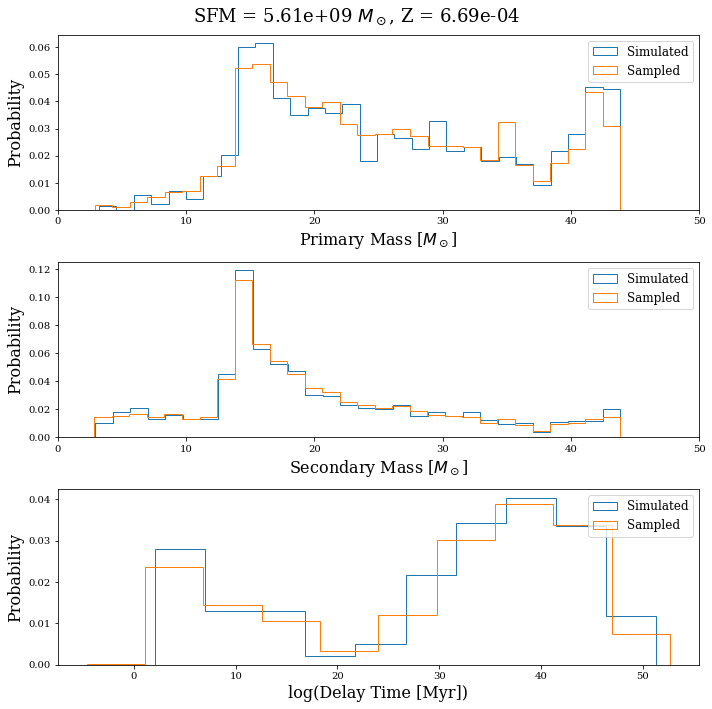

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

fig.suptitle(f"SFM = {SFM:.2e} $M_\odot$, Z = {MET:.2e}", fontsize=18)

bins = 30

ax1.hist(M1_SIMULATED, bins=bins, histtype='step', density=True, label=f'Simulated') 
# ax1.hist(M1_SAMPLED, bins=bins, histtype='step', density=True, label=f'Sampled')
ax1.hist(M1_SAMPLED_TRIMMED, bins=bins, histtype='step', density=True, label=f'Sampled')

ax1.set_xlabel("Primary Mass [$M_\odot$]", fontsize=16)
ax1.set_ylabel("Probability", fontsize=16)

ax1.set_xlim(0,50)
ax1.legend(fontsize=12)

ax2.hist(M2_SIMULATED, bins=bins, histtype='step', density=True, label=f'Simulated') 
# ax2.hist(M2_SAMPLED, bins=bins, histtype='step', density=True, label=f'Sampled')
ax2.hist(M2_SAMPLED_TRIMMED, bins=bins, histtype='step', density=True, label=f'Sampled')
ax2.set_xlabel("Secondary Mass [$M_\odot$]", fontsize=16)
ax2.set_xlim(0,50)
ax2.legend(fontsize=12)
ax2.set_ylabel("Probability", fontsize=16)


ax3.hist(np.log(DELAY_TIME_SIMULATED), histtype='step', density=True, label=f'Simulated') 
ax3.hist(np.log(DELAY_TIME_SAMPLED), histtype='step', density=True, label=f'Sampled')

ax3.set_xlabel("log(Delay Time [Myr])", fontsize=16)
ax3.legend(fontsize=12)
ax3.set_ylabel("Probability", fontsize=16)

plt.tight_layout()
plt.show()

In [82]:
def plot_kde(SIMULATED, SAMPLED, xlabel, N_kde = 200):
    f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
    plt.title(f"SFM = {SFM:.2e} $M_\odot$, Z = {MET:.2e}", fontsize=18)

    kde_SIM = gaussian_kde( SIMULATED )
    kde_SIM_dist_space = linspace( min(SIMULATED), max(SIMULATED), N_kde )
    plt.plot( kde_SIM_dist_space, kde_SIM(kde_SIM_dist_space), label='Simulated');


    kde_SAMPLED = gaussian_kde( SAMPLED )
    kde_SAMPLED_dist_space = linspace( min(SAMPLED), max(SAMPLED), N_kde )
    plt.plot( kde_SAMPLED_dist_space, kde_SAMPLED(kde_SAMPLED_dist_space), label='Sampled');


    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel("Probability", fontsize=16)


    plt.legend(fontsize=14)
    plt.show()

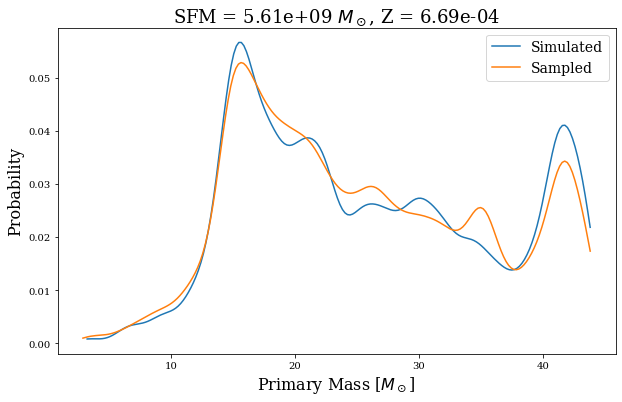

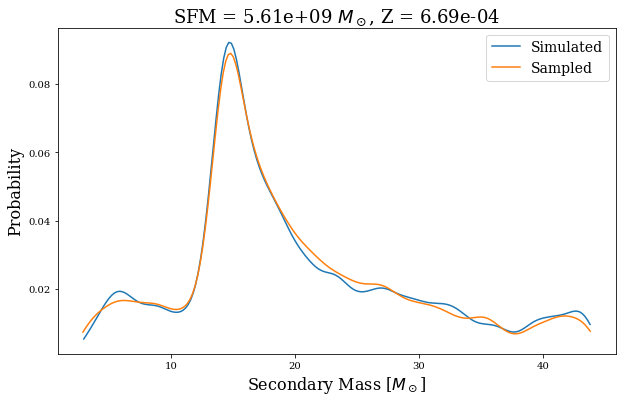

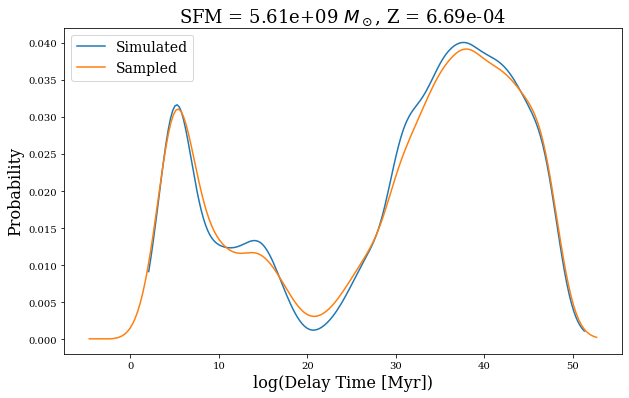

In [79]:
plot_kde(M1_SIMULATED[:], M1_SAMPLED_TRIMMED[:], "Primary Mass [$M_\odot$]")
plot_kde(M2_SIMULATED, M2_SAMPLED_TRIMMED, "Secondary Mass [$M_\odot$]")
plot_kde(np.log(DELAY_TIME_SIMULATED), np.log(DELAY_TIME_SAMPLED), "log(Delay Time [Myr])")

# KS Test

In [55]:
from scipy.stats import *

In [56]:
ks_stat, p_value = ks_2samp(M1_SAMPLED[:], M1_SIMULATED[:], mode='asymp')
print(f'KS statistic for M1: {ks_stat}')
print(f'p value for M1: {p_value}')

KS statistic for M1: 0.03379601276996669
p value for M1: 1.6086473706919228e-47


In [57]:
ks_stat, p_value = ks_2samp(M2_SAMPLED[:], M2_SIMULATED[:])
print(f'KS statistic for M2: {ks_stat}')
print(f'p value for M2: {p_value}')

KS statistic for M2: 0.015528496483710852
p value for M2: 2.2804487022953182e-10


In [58]:
ks_stat, p_value = ks_2samp(DELAY_TIME_SAMPLED[:], DELAY_TIME_SIMULATED[:])
print(f'KS statistic for Delay Time: {ks_stat}')
print(f'p value for Delay Time: {p_value}')

KS statistic for Delay Time: 0.020721181273439748
p value for Delay Time: 3.959279038344863e-18


The KS test seems ill-suited for this application. It looks like the sample size is too big, which leads to very low p-values. For a large sample size, the tiny differences between the two data sets become statistically ~significant, so we probably cannot rely on the KS test here to determine if the sampled and simulated data belong to the same underlying distributions.

If, however, we calculate the PDFs/CDFs of the distributions and THEN perform a KS test, we might see some more meaningful results.

In [59]:
def plot_cdf(SIMULATED, SAMPLED, xlabel, n_bins=20):
    f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

    plt.title('CDF')
    pdf_SIM = gaussian_kde(SIMULATED)
    x_SIM = np.linspace(min(SIMULATED), max(SIMULATED), 100)
    cdf_SIM = np.vectorize(lambda x: pdf_SIM.integrate_box_1d(-np.inf, x))
    plt.plot(x_SIM, cdf_SIM(x_SIM), label='Simulated')
    
    pdf_SAMPLED = gaussian_kde(SAMPLED)
    x_SAMPLED = np.linspace(min(SAMPLED), max(SAMPLED), 100)
    cdf_SAMPLED = np.vectorize(lambda x: pdf_SAMPLED.integrate_box_1d(-np.inf, x))
    plt.plot(x_SAMPLED, cdf_SAMPLED(x_SAMPLED), label='Sampled')

    ax.set_xlabel(xlabel, fontsize=16)

    plt.legend(fontsize=14)
    plt.show()
#     print(ks_2samp(SAMPLED, cdf_SIM))


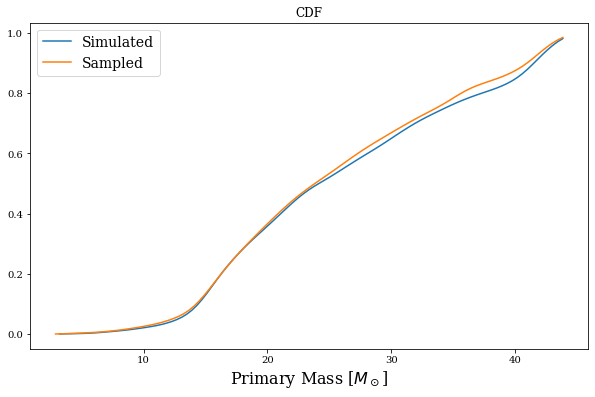

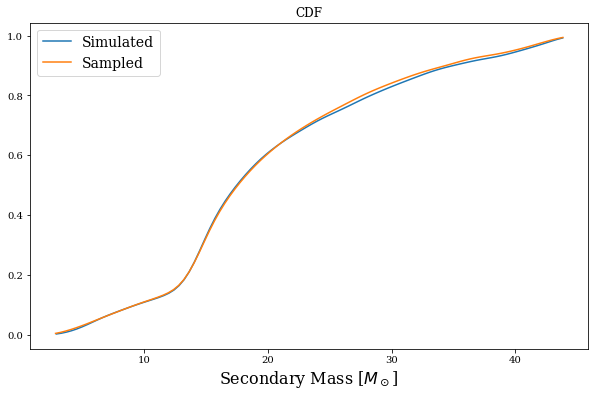

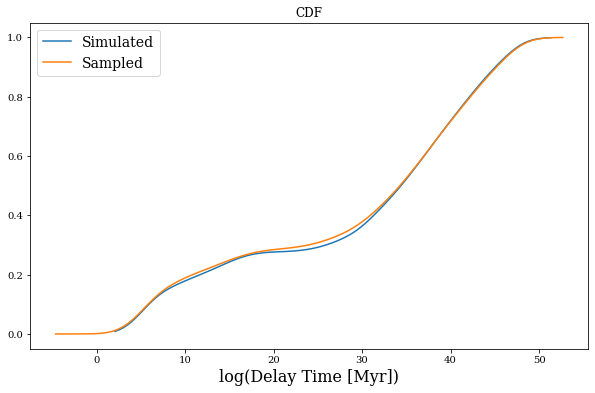

In [75]:
M1_SAMPLED_TRIMMED = [x for x in M1_SAMPLED if x <= 50.]

plot_cdf(M1_SIMULATED[:], M1_SAMPLED_TRIMMED[:], "Primary Mass [$M_\odot$]")
plot_cdf(M2_SIMULATED[:], M2_SAMPLED_TRIMMED[:], "Secondary Mass [$M_\odot$]")
plot_cdf(np.log(DELAY_TIME_SIMULATED), np.log(DELAY_TIME_SAMPLED), "log(Delay Time [Myr])")

Now, all three data sets have p values > 0.05, meaning that we cannot reject the null hypothesis, i.e. that the simulated and sampled data are drawn from the same underlying distribution.

# (Working out the code)

In [34]:
# set some arbitrary values of sfm, Z
SFM = 3.7e6
MET = 0.000259

In [35]:
met_sfm_to_n_bbh = cbt.interpolate_n_bbh(sfm, metallicities, M1_BBH_ALL)

In [36]:
n_bbh = met_sfm_to_n_bbh(MET, SFM)
print(n_bbh)

[60.06792385]


In [37]:
weights = cbt.met_to_met_weights(MET, metallicities)
print(weights)

[1.73504530e-01 2.85736373e-01 2.85967190e-01 1.73925338e-01
 6.42843827e-02 1.44392312e-02 1.97096372e-03 1.63496765e-04
 8.24205799e-06 2.52498114e-07]


In [38]:
n_met_samples = (weights*n_bbh).astype(int)
print(n_met_samples)
print(np.sum(n_met_samples))

[10 17 17 10  3  0  0  0  0  0]
57


In [39]:
M1_BBH_METS = cbt.flatten_list_by_met(sfm, metallicities, M1_BBH_ALL)
M2_BBH_METS = cbt.flatten_list_by_met(sfm, metallicities, M2_BBH_ALL)
DELAY_TIMES_METS = cbt.flatten_list_by_met(sfm, metallicities, DELAY_TIMES_BBH_ALL)

NameError: name 'M2_BBH_ALL' is not defined

In [40]:
len(M1_BBH_ALL)

60

In [41]:
M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.draw_bbh_from_met(n_met_samples, metallicities, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS)

In [43]:
len(M1_SAMPLED)

10

## Star Forming Mass-Z-N_BBH Relation

In [182]:
N_BBH = np.zeros(len(M1_BBH_ALL))
for i in range(len(N_BBH)):
    N_BBH[i] = len(M1_BBH_ALL[i])

In [183]:
N_BBH_GRID = np.reshape(N_BBH, (len(sfm), len(metallicities)))
np.shape(N_BBH_GRID)

(6, 10)

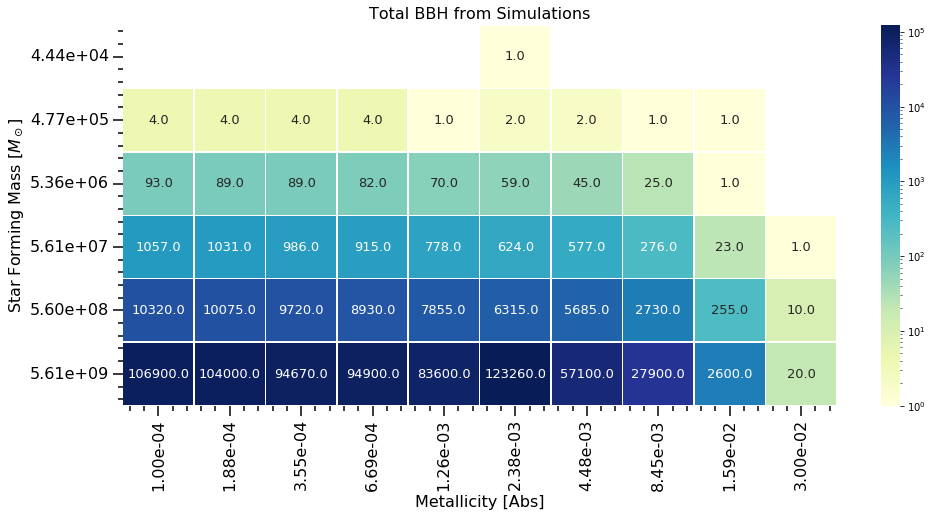

In [190]:
# original grid
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(N_BBH_GRID, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=metallicities, yticklabels=sfm, \
                annot=N_BBH_GRID, annot_kws={'fontsize':13}, fmt='.1f')

cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Total BBH from Simulations", fontsize=16)

plt.show()

In [195]:
met_sfm_to_n_bbh = interpolate.interp2d(metallicities, sfm, N_BBH_GRID)

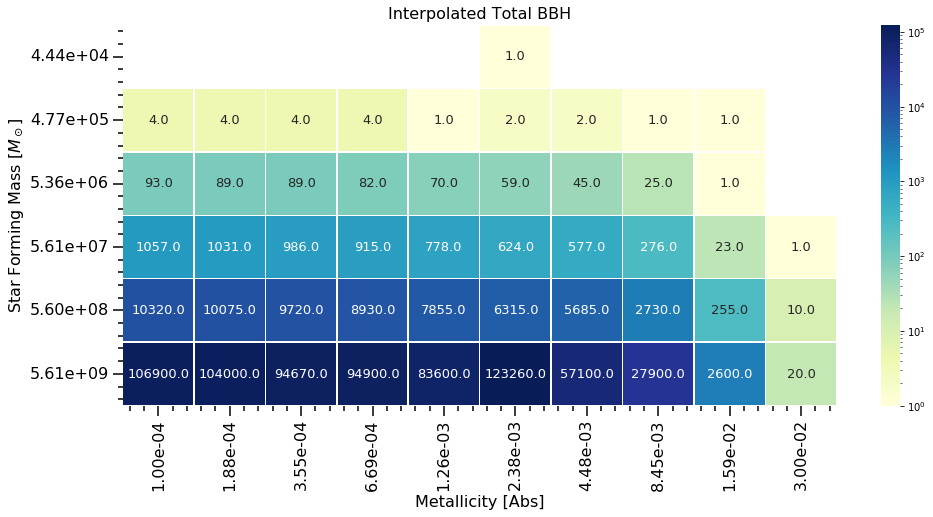

In [196]:
# original grid (interpolated)
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(met_sfm_to_n_bbh(metallicities, sfm), cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=metallicities, yticklabels=sfm, \
                annot=met_sfm_to_n_bbh(metallicities, sfm), annot_kws={'fontsize':13}, fmt='.1f')

cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Interpolated Total BBH", fontsize=16)

plt.show()

That matches the true values exactly, now let's try some new values.

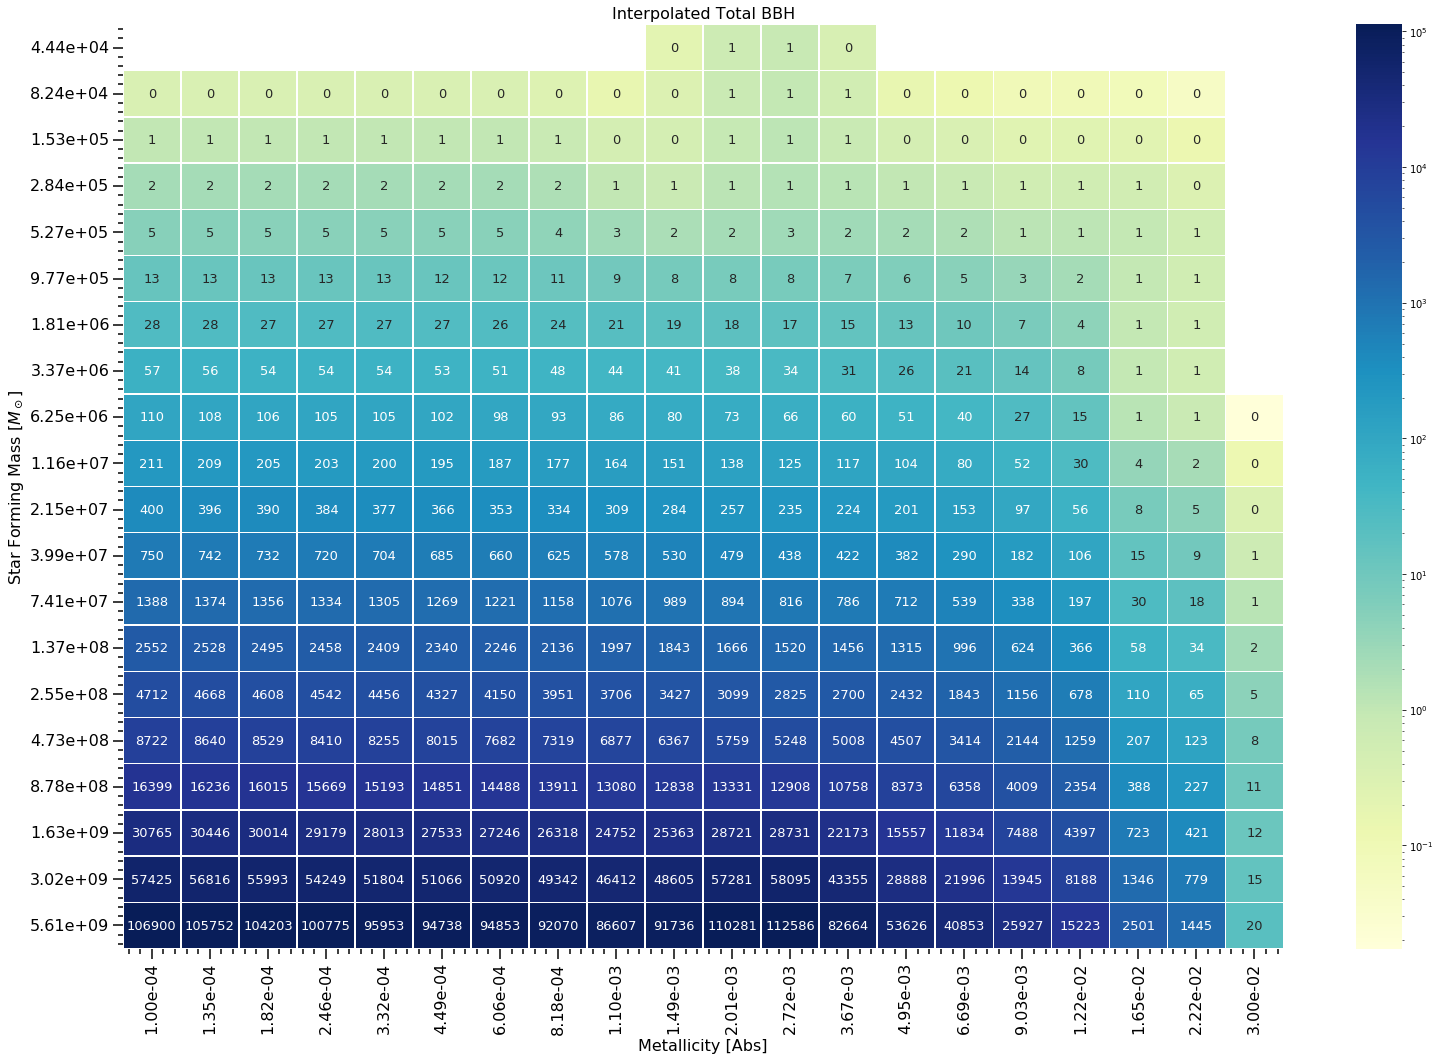

In [199]:
m = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 20)
s = np.logspace(np.log10(sfm[0]), np.log10(sfm[-1]), 20)

f, ax= plt.subplots(1, 1,  figsize=(26,17)) 

ax = sns.heatmap(met_sfm_to_n_bbh(m, s), cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=m, yticklabels=s, \
                annot=met_sfm_to_n_bbh(m,s), annot_kws={'fontsize':13}, fmt='.0f')

cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Interpolated Total BBH", fontsize=16)

plt.show()

The interpolation is fine within the bounds of the original simulations. Outside, it starts leveling out. This is because the 2d extrapolation is 'nearest neighbor', whereas the 1d extrapolation is proper extrapolation. See https://github.com/scipy/scipy/issues/8099 for more info.

For now, we will assume that the SFM and Metallicities will all be within the simulated range. If there are any values outside, we will first have to use interp1d to extend the data range, and then use interp2d.

Now that we have a number of BBHs, how do we actually draw them?
One way would be to reassign the metallicities across all BBHs so that they form a ~continuous distribution of metallicities. See Fig. 10 and Eq. (48) https://arxiv.org/pdf/2109.10352.pdf to see how we can assign a gaussian distribution centered around each Z value.

Then, given a metallicity value, we can find the relative contribution from each Z gaussian, and draw the appropriate # of BBHs from that Z simulation.

## Metallicity value to set of BBHs

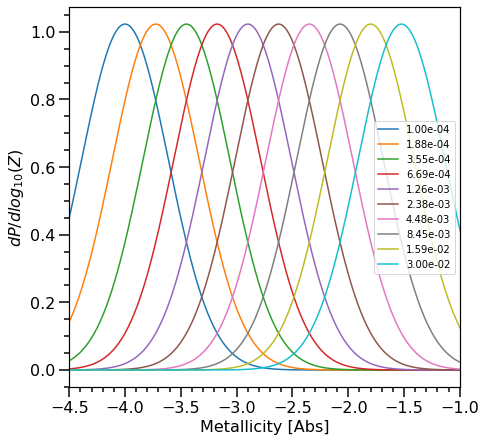

In [226]:
f, ax= plt.subplots(1, 1,  figsize=(7,7)) 

x = np.linspace(Z_MIN_LOG-2, Z_MAX_LOG+2, 500)
SIGMA_Z = 0.39

for met in np.log10(metallicities):
    mu = met
    ax.plot(x, stats.norm.pdf(x, mu, SIGMA_Z), label=f'{10**met:.2e}')
    
cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='$dP/dlog_{10}(Z)$', fontsize=16)
plt.legend()
plt.xlim(-4.5, -1.0)
plt.show()
    

In [107]:
from scipy.stats import norm
def met_to_met_weights(met, metallicities):
    SIGMA_Z = 0.39
    log_metallicities = np.log10(metallicities)
    log_met = np.log10(met)
    weights = np.zeros(len(log_metallicities))
    
    for i in range(len(log_metallicities)):
        mu = log_metallicities[i]
        weights[i] = norm.pdf(log_met, mu, SIGMA_Z)
    weights = weights/np.sum(weights)
    return weights    

In [109]:
met = 2.463e-4
weights = met_to_met_weights(met, metallicities)
print(weights)

[1.85503807e-01 2.93661780e-01 2.82512714e-01 1.65167478e-01
 5.86822893e-02 1.26702601e-02 1.66249360e-03 1.32565467e-04
 6.42387080e-06 1.89173005e-07]


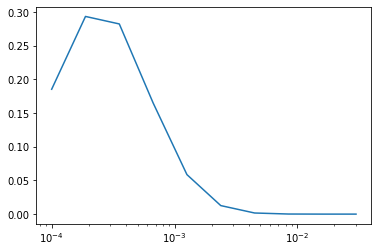

In [112]:
plt.plot(metallicities, weights)
plt.semilogx()
cbt.layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='$dP/dlog_{10}(Z)$', fontsize=16)
plt.show()